/tmp/ipykernel_198122/3038562785.py:534: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


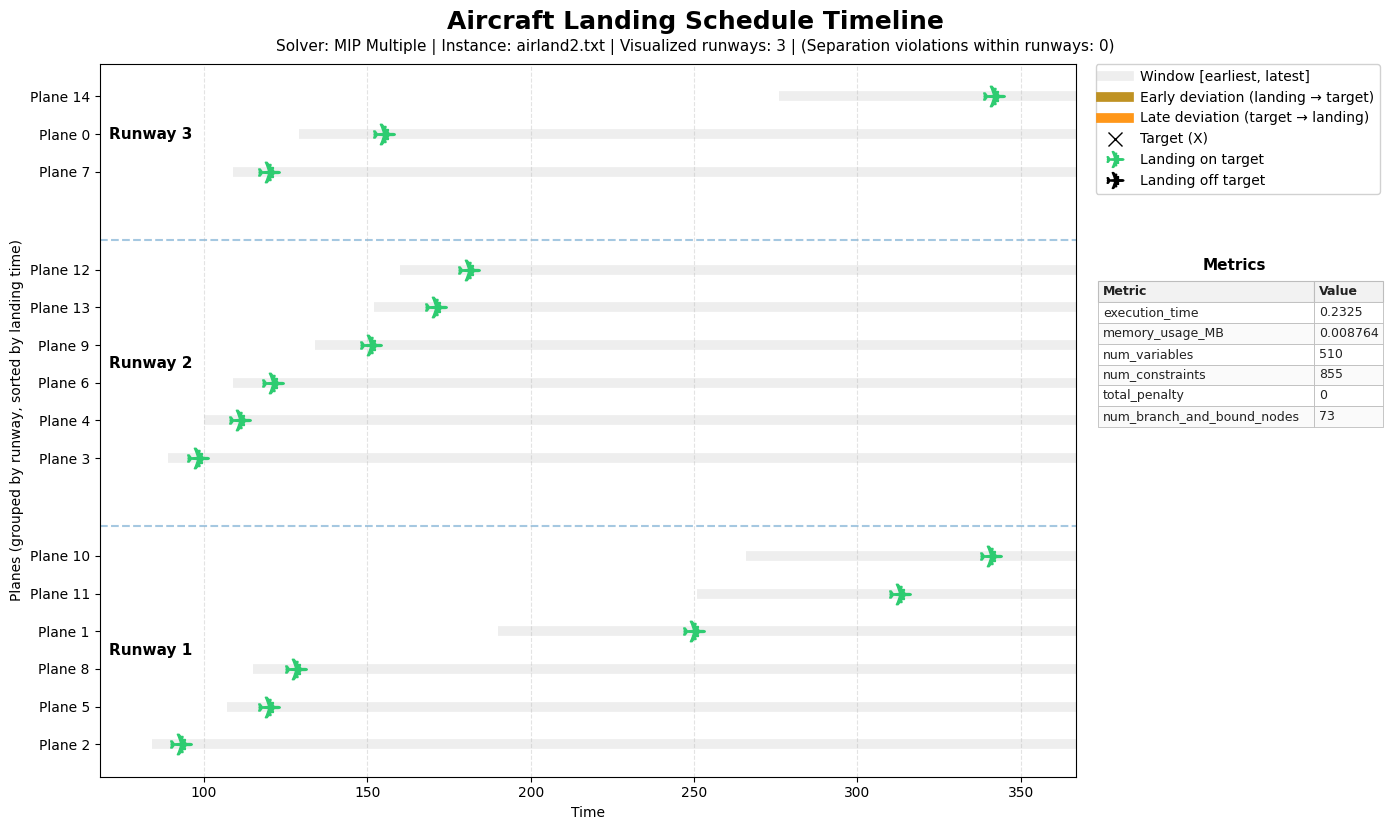

In [ ]:
import json
import os
import ast
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt


# -----------------------------
# TXT parsing (Airland / ALP)
# -----------------------------

@dataclass
class PlaneWindow:
    idx: int
    appearance: float
    earliest: float
    target: float
    latest: float
    g: float
    h: float


@dataclass
class AirlandInstance:
    n: int
    header2: int
    planes: List[PlaneWindow]
    sep: List[List[float]]


def read_airland_txt(txt_path: str) -> AirlandInstance:
    with open(txt_path, "r", encoding="utf-8") as f:
        tokens = f.read().split()

    pos = 0
    n = int(tokens[pos]); pos += 1
    header2 = int(tokens[pos]); pos += 1

    planes: List[PlaneWindow] = []
    sep = [[0.0 for _ in range(n)] for _ in range(n)]

    for i in range(n):
        appearance = float(tokens[pos]); pos += 1
        earliest = float(tokens[pos]); pos += 1
        target = float(tokens[pos]); pos += 1
        latest = float(tokens[pos]); pos += 1
        g = float(tokens[pos]); pos += 1
        h = float(tokens[pos]); pos += 1

        planes.append(PlaneWindow(i, appearance, earliest, target, latest, g, h))

        for j in range(n):
            sep[i][j] = float(tokens[pos]); pos += 1

    return AirlandInstance(n=n, header2=header2, planes=planes, sep=sep)


# -----------------------------
# Robust JSON loading
# -----------------------------

def load_json_robust(path: str):
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()

    try:
        return json.loads(text)
    except json.JSONDecodeError:
        return ast.literal_eval(text)


# -----------------------------
# JSON parsing (multi-solver)
# -----------------------------

def load_multi_solver_json(json_path: str) -> Dict[str, List[dict]]:
    data = load_json_robust(json_path)

    if not isinstance(data, dict):
        raise ValueError("Invalid solutions file: expected a dict {solver_name: [solutions...]}")

    out: Dict[str, List[dict]] = {}
    for solver, sols in data.items():
        if not isinstance(sols, list):
            raise ValueError(f"Invalid solutions file: solver '{solver}' must map to a list of solutions.")
        out[str(solver)] = sols
    return out


def _safe_int(x, default: int = 1) -> int:
    try:
        return int(x)
    except Exception:
        return default


def find_solution(
    solutions_by_solver: Dict[str, List[dict]],
    solver: str,
    file_name: str,
    desired_num_runways: Optional[int] = None,
) -> dict:
    if solver not in solutions_by_solver:
        raise ValueError(f"Solver '{solver}' not found. Available: {list(solutions_by_solver.keys())}")

    candidates = [sol for sol in solutions_by_solver[solver] if str(sol.get("file", "")).strip() == file_name]
    if not candidates:
        available_files = [s.get("file") for s in solutions_by_solver[solver]]
        raise ValueError(
            f"Solution for file='{file_name}' not found under solver '{solver}'.\n"
            f"Available files for this solver: {available_files}"
        )

    if desired_num_runways is not None:
        exact = [c for c in candidates if _safe_int(c.get("num_runways", 1)) == int(desired_num_runways)]
        if exact:
            exact.sort(key=lambda c: len(c.get("landing_times", [])), reverse=True)
            return exact[0]

    candidates.sort(
        key=lambda c: (_safe_int(c.get("num_runways", 1)), len(c.get("landing_times", []))),
        reverse=True
    )
    return candidates[0]


def landing_times_and_runways(solution: dict) -> Tuple[Dict[int, float], Dict[int, int]]:
    lt: Dict[int, float] = {}
    rw: Dict[int, int] = {}

    for row in solution.get("landing_times", []):
        p = int(row["plane"])
        lt[p] = float(row["landing_time"])

        if "runway" not in row or row["runway"] is None:
            raise ValueError(f"Missing 'runway' for plane {p} in solution for file={solution.get('file')}.")
        rw[p] = int(row["runway"])

    return lt, rw


def build_runway_mapping(
    instance: AirlandInstance,
    landing_times: Dict[int, float],
    num_runways: int,
    json_runways: Dict[int, int],
) -> Tuple[Dict[int, int], List[Tuple[int, int]]]:
    missing = [p for p in landing_times.keys() if p not in json_runways]
    if missing:
        raise ValueError(f"Missing runway for planes: {missing}")

    runway_of_plane: Dict[int, int] = {p: int(json_runways[p]) for p in landing_times.keys()}

    violations: List[Tuple[int, int]] = []
    runway_to_planes: Dict[int, List[int]] = {}
    for p, r in runway_of_plane.items():
        runway_to_planes.setdefault(r, []).append(p)

    for r, planes in runway_to_planes.items():
        planes.sort(key=lambda p: landing_times[p])
        for i in range(1, len(planes)):
            prev_p = planes[i - 1]
            p = planes[i]
            gap = landing_times[p] - landing_times[prev_p]
            required = instance.sep[prev_p][p]
            if gap < required:
                violations.append((prev_p, p))

    return runway_of_plane, violations


# -----------------------------
# Metrics helpers
# -----------------------------

def _flatten_metrics(d: Dict[str, Any], prefix: str = "") -> Dict[str, Any]:
    out: Dict[str, Any] = {}
    for k, v in d.items():
        key = f"{prefix}{k}" if not prefix else f"{prefix}.{k}"
        if isinstance(v, dict):
            for kk, vv in v.items():
                out[f"{key}.{kk}"] = vv
        else:
            out[key] = v
    return out


def load_metrics(metrics_json_path: str) -> Any:
    return load_json_robust(metrics_json_path)


def find_metrics_record(
    metrics_data: Any,
    solver: str,
    file_name: str,
    num_runways: int,
) -> Optional[Dict[str, Any]]:
    candidates: List[Dict[str, Any]] = []

    def consider(rec: Any, solver_hint: Optional[str] = None):
        if not isinstance(rec, dict):
            return
        f = str(rec.get("file", "")).strip()
        if f != file_name:
            return

        rws = rec.get("num_runways", rec.get("runways", rec.get("k_runways", None)))
        if rws is not None and _safe_int(rws, default=-999) != int(num_runways):
            return

        rec_solver = rec.get("solver", None)
        if rec_solver is not None and str(rec_solver) != solver:
            return

        if solver_hint is not None and solver_hint != solver:
            return

        candidates.append(rec)

    if isinstance(metrics_data, dict) and any(isinstance(v, list) for v in metrics_data.values()):
        if solver in metrics_data and isinstance(metrics_data[solver], list):
            for rec in metrics_data[solver]:
                consider(rec, solver_hint=solver)
        else:
            for s, lst in metrics_data.items():
                if isinstance(lst, list):
                    for rec in lst:
                        consider(rec, solver_hint=str(s))

    if isinstance(metrics_data, dict) and isinstance(metrics_data.get("records", None), list):
        for rec in metrics_data["records"]:
            consider(rec, solver_hint=None)

    if isinstance(metrics_data, list):
        for rec in metrics_data:
            consider(rec, solver_hint=None)

    if not candidates:
        return None

    candidates.sort(key=lambda r: len(r.keys()), reverse=True)
    return candidates[0]


# -----------------------------
# Plotting helpers
# -----------------------------

def landing_color(t: float, target: float, eps: float = 1e-9) -> str:
    ON_TARGET_GREEN = "#2ECC71"
    if abs(t - target) <= eps:
        return ON_TARGET_GREEN
    return "black"


def compute_zoom_limits(instance: AirlandInstance, landing_times: Dict[int, float], pad: float = 25.0) -> Tuple[float, float]:
    xs: List[float] = []
    for i in range(instance.n):
        pw = instance.planes[i]
        xs.append(pw.target)
        if i in landing_times:
            xs.append(landing_times[i])

    xmin = min(xs) - pad
    xmax = max(xs) + pad

    if xmax - xmin < 40:
        mid = 0.5 * (xmin + xmax)
        xmin = mid - 30
        xmax = mid + 30

    return xmin, xmax


def plot_landing_gantt_multi_runway(
    instance: AirlandInstance,
    landing_times: Dict[int, float],
    runway_of_plane: Dict[int, int],
    num_runways: int,
    fancy_title: str,
    subtitle: str,
    metrics: Optional[Dict[str, Any]] = None,
    zoom: bool = True,
):
    WINDOW_COLOR = "#D0D0D0"
    EARLY_SEG = "#B8860B"
    LATE_SEG  = "#FF8C00"
    TARGET_COLOR = "black"
    ON_TARGET_GREEN = "#2ECC71"

    runway_ids = list(range(num_runways))

    runway_to_planes: Dict[int, List[int]] = {rid: [] for rid in runway_ids}
    for p, t in landing_times.items():
        rid = int(runway_of_plane[p])
        if rid in runway_to_planes:
            runway_to_planes[rid].append(p)

    for rid in runway_ids:
        runway_to_planes[rid].sort(key=lambda p: landing_times[p])

    gap = 1.6
    y_positions: Dict[int, float] = {}
    runway_bounds: List[Tuple[int, float, float]] = []

    y_cursor = 0.0
    for rid in runway_ids:
        planes = runway_to_planes[rid]
        ymin = y_cursor

        if planes:
            for p in planes:
                y_positions[p] = y_cursor
                y_cursor += 1.0
            ymax = y_cursor - 1.0
        else:
            ymax = y_cursor
            y_cursor += 1.0

        runway_bounds.append((rid, ymin, ymax))
        y_cursor += gap

    fig_h = max(6, 0.55 * max(10, len(landing_times)))
    fig, ax = plt.subplots(figsize=(14, fig_h))

    for p, t in landing_times.items():
        y = y_positions[p]
        pw = instance.planes[p]

        ax.hlines(
            y=y,
            xmin=pw.earliest,
            xmax=pw.latest,
            linewidth=7,
            alpha=0.35,
            zorder=1,
            color=WINDOW_COLOR,
        )

        if abs(t - pw.target) > 1e-9:
            seg_color = EARLY_SEG if t < pw.target else LATE_SEG

            ax.hlines(
                y=y,
                xmin=min(t, pw.target),
                xmax=max(t, pw.target),
                linewidth=7,
                alpha=0.90,
                zorder=2,
                color=seg_color,
            )

            ax.scatter(
                [pw.target], [y],
                marker="x",
                s=80,
                linewidths=2,
                zorder=4,
                color=TARGET_COLOR,
            )

        ax.scatter(
            [t], [y],
            marker=r"$✈$",
            s=240,
            c=landing_color(t, pw.target),
            zorder=5,
        )

    for i, (rid, ymin, ymax) in enumerate(runway_bounds):
        y_label = 0.5 * (ymin + ymax)
        ax.text(
            0.01, y_label,
            f"Runway {rid + 1}",
            transform=ax.get_yaxis_transform(),
            va="center",
            fontsize=11,
            fontweight="bold",
        )
        if i < len(runway_bounds) - 1:
            sep_y = ymax + (gap / 2.0)
            ax.axhline(sep_y, linestyle="--", alpha=0.4, zorder=0)

    planes_in_order = sorted(y_positions.items(), key=lambda kv: kv[1])
    ax.set_yticks([y for _, y in planes_in_order])
    ax.set_yticklabels([f"Plane {p}" for p, _ in planes_in_order])

    ax.set_xlabel("Time")
    ax.set_ylabel("Planes (grouped by runway, sorted by landing time)")

    plt.tight_layout(rect=[0, 0, 1, 0.90])

    fig.suptitle(
        fancy_title,
        fontsize=18,
        fontweight="bold",
        y=1.0
    )

    fig.text(
        0.5,
        0.965,
        subtitle,
        ha="center",
        va="top",
        fontsize=11
    )


    ax.grid(True, axis="x", linestyle="--", alpha=0.35)

    legend_handles = [
        Line2D([0], [0], color=WINDOW_COLOR, linewidth=7, alpha=0.35, label="Window [earliest, latest]"),
        Line2D([0], [0], color=EARLY_SEG, linewidth=7, alpha=0.90, label="Early deviation (landing → target)"),
        Line2D([0], [0], color=LATE_SEG,  linewidth=7, alpha=0.90, label="Late deviation (target → landing)"),
        Line2D([0], [0], marker="x", linestyle="None", markersize=10, color="black", label="Target (X)"),
        Line2D([0], [0], marker=r"$✈$", linestyle="None", markersize=12, color=ON_TARGET_GREEN, label="Landing on target"),
        Line2D([0], [0], marker=r"$✈$", linestyle="None", markersize=12, color="black", label="Landing off target"),
    ]

    legend = ax.legend(
        handles=legend_handles,
        loc="upper left",
        bbox_to_anchor=(1.02, 1.0),
        borderaxespad=0.0,
        framealpha=0.9
    )
    fig.subplots_adjust(right=0.78)

    # -----------------------------
    # Metrics table (FIXED ALIGN + FULL TEXT)
    # -----------------------------
    if metrics is not None:
        cleaned = dict(metrics)
        for k in ["file", "solver", "num_runways", "runways", "k_runways"]:
            cleaned.pop(k, None)

        flat = _flatten_metrics(cleaned)

        rows: List[Tuple[str, str]] = []
        for k, v in flat.items():
            if isinstance(v, (list, dict)):
                continue
            if isinstance(v, float):
                rows.append((str(k), f"{v:.4g}"))
            else:
                rows.append((str(k), str(v)))

        rows = rows[:18] if rows else [("metrics", "not available")]

        # slightly wider area so long metric names can show fully
        fig.canvas.draw()
        bbox = legend.get_window_extent(fig.canvas.get_renderer())
        bbox_fig = bbox.transformed(fig.transFigure.inverted())

        dx = 0.01  # left
        dy = 0.05  # down

        metrics_ax = fig.add_axes([
            bbox_fig.x0 - dx,
            bbox_fig.y0 - bbox_fig.height - dy,
            bbox_fig.width,
            bbox_fig.height
        ])

        metrics_ax.axis("off")
        metrics_ax.set_title("Metrics", fontsize=11, pad=6, fontweight="bold")

        cell_text = [[k, v] for k, v in rows]
        table = metrics_ax.table(
            cellText=cell_text,
            colLabels=["Metric", "Value"],
            loc="upper left",
            cellLoc="left",
            colLoc="left",
        )

        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.0, 1.25)

        # Left column wider, right column tight
        left_w, right_w = 0.76, 0.24

        for (r, c), cell in table.get_celld().items():
            # subtle borders
            cell.set_edgecolor("#BDBDBD")
            cell.set_linewidth(0.6)

            # IMPORTANT: remove extra left padding so left column starts immediately
            if c == 0:
                cell.PAD = 0.02   # coluna "Metric"
            else:
                cell.PAD = 0.07   # coluna "Value" (mais espaço à esquerda)  # small, consistent padding for BOTH columns (left starts like right)

            # header styling
            if r == 0:
                cell.set_facecolor("#F2F2F2")
                cell.set_text_props(weight="bold", color="#222222")
                cell.set_linewidth(0.8)
            else:
                cell.set_facecolor("#FFFFFF" if (r % 2 == 1) else "#FAFAFA")
                cell.set_text_props(color="#222222")

            # widths
            if c == 0:
                cell.set_width(left_w)
            else:
                cell.set_width(right_w)

            # ensure text is really left-aligned inside the cell
            txt = cell.get_text()
            txt.set_ha("left")
            txt.set_va("center")

            # make sure long metric names show fully (wrap if needed)
            txt.set_wrap(True)

        metrics_ax.set_xlim(0, 1)
        metrics_ax.set_ylim(0, 1)

    if zoom and landing_times:
        xmin, xmax = compute_zoom_limits(instance, landing_times, pad=25.0)
        ax.set_xlim(xmin, xmax)

    plt.tight_layout()
    plt.show()


# -----------------------------
# Main
# -----------------------------

def main(
    txt_path: str,
    solutions_json_path: str,
    metrics_json_path: str,
    solver: str,
    runways_to_visualize: Optional[int] = None,
    file_name_in_json: Optional[str] = None,
    zoom: bool = True,
):
    instance = read_airland_txt(txt_path)
    solutions_by_solver = load_multi_solver_json(solutions_json_path)

    file_name = file_name_in_json or os.path.basename(txt_path)

    sol = find_solution(
        solutions_by_solver,
        solver=solver,
        file_name=file_name,
        desired_num_runways=runways_to_visualize,
    )

    lt, json_runways = landing_times_and_runways(sol)

    json_runways_count = sol.get("num_runways", 1)
    json_runways_count = _safe_int(json_runways_count, default=1)

    num_runways = int(runways_to_visualize) if runways_to_visualize is not None else json_runways_count
    num_runways = max(1, num_runways)

    runway_of_plane, violations = build_runway_mapping(
        instance=instance,
        landing_times=lt,
        num_runways=num_runways,
        json_runways=json_runways,
    )

    metrics_data = load_metrics(metrics_json_path)
    metrics_rec = find_metrics_record(
        metrics_data=metrics_data,
        solver=solver,
        file_name=file_name,
        num_runways=num_runways,
    )

    fancy_title = "Aircraft Landing Schedule Timeline"
    subtitle = (
        f"Solver: {solver} | Instance: {file_name} | Visualized runways: {num_runways}"
        f" | (Separation violations within runways: {len(violations)})")


    plot_landing_gantt_multi_runway(
        instance=instance,
        landing_times=lt,
        runway_of_plane=runway_of_plane,
        num_runways=num_runways,
        fancy_title=fancy_title,
        subtitle=subtitle,
        metrics=metrics_rec,
        zoom=zoom,
    )


if __name__ == "__main__":
    main(
        txt_path="data/airland2.txt",
        solutions_json_path="results/solutions.json",
        metrics_json_path="results/metrics.json",
        solver="MIP Multiple",
        runways_to_visualize=3,
        file_name_in_json="airland2.txt",
        zoom=True
    )
